In [1]:
# Imports here
import pandas as pd
import numpy as np
import os

# Data filtering
import scipy.stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import sklearn
import seaborn as sns; sns.set(color_codes=True) 

from ml_lib import *

%matplotlib inline

In [2]:
cohortDir = "/home/jenna/Research/data/Preadolescents/"

siteClasses = []
subjId = []
fd_dag = []
dvars_dag = []
cr = []
mi = []
# dice = []
fd_bold = []
dvars_bold = []

# Read features from .csv files

In [3]:
def readList(fn):
    data = pd.read_csv(fn, header=None)    
    return data.values.flatten().tolist()

In [4]:
def readTable(fn):
    data = pd.read_csv(fn, header=None)
    return data.values # returns a numpy array

In [5]:
# Get sorted list of sites
sites = sorted([site.path for site in os.scandir(cohortDir) if site.is_dir()])
# for each site
for site in sites:
    # Get sorted list of subjects
    subjects = sorted([os.path.join(subj.path, "metrics") for subj in os.scandir(site) if os.path.exists(os.path.join(subj, 'metrics'))])
    print(site, len(subjects))
    # for subject in site
    for subject in subjects:
        
        # read in FD
        fd_reg = readList(os.path.join(subject, "corrected_dag-displacement-metrics.csv"))
        # read in DVARS
        dvars_reg = readList(os.path.join(subject, "corrected_dag-intensity-metrics.csv"))
        # read in FD
        fd_orig = readList(os.path.join(subject, "BOLD-displacement-metrics.csv"))
        # read in DVARS
        dvars_orig = readList(os.path.join(subject, "BOLD-intensity-metrics.csv"))
        
        if fd_reg not in fd_dag and dvars_reg not in dvars_dag and fd_orig not in fd_bold and dvars_orig not in dvars_bold: 
            siteClasses.extend([site.split("/")[-1]])
            subjId.append(subject.split("/")[-2])
            fd_dag.append(fd_reg)
            dvars_dag.append(dvars_reg)
            fd_bold.append(fd_orig)
            dvars_bold.append(dvars_orig)

        # read in correlation ratio matrix
#         cr.append(convertTableToList(readTable(os.path.join(subject, "dag-correlation-matrix.csv")))[:150])
        # read in mutual information matrix (calculated using fsl)
#         mi.append(convertTableToList(readTable(os.path.join(subject, "dag-fsl-mi-matrix.csv")))[:150])

        

/home/jenna/Research/data/Preadolescents/BOSTON 95
/home/jenna/Research/data/Preadolescents/CCHMC 8
/home/jenna/Research/data/Preadolescents/CHLA 24
/home/jenna/Research/data/Preadolescents/CHOP 97
/home/jenna/Research/data/Preadolescents/COLUMBIA 6
/home/jenna/Research/data/Preadolescents/DUKE 10
/home/jenna/Research/data/Preadolescents/EMORY 10
/home/jenna/Research/data/Preadolescents/MUSC 14
/home/jenna/Research/data/Preadolescents/UTAH 4
/home/jenna/Research/data/Preadolescents/WISC 26


# Calculate usability statistics

In [6]:
## Looking only at image volumes
# Total
print("Total image volumes:    ", len([i for sublist in fd_dag for i in sublist]))

# FD
print(np.asarray(fd_dag[0]).shape)
# for i in np.asarray(fd_dag).flatten():
#     print(i)
count_fd = len([1 for sublist in fd_dag for i in sublist if i < 0.2])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for sublist in dvars_dag for i in sublist if i < 25])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip([k for sublist in fd_dag for k in sublist], [m for sublist in dvars_dag for m in sublist]) if i < 0.2 and j < 25])
print("# volumes meeting both: ", count_both)

Total image volumes:     84094
(470,)
# volumes meeting FD:    12117
# volumes meeting DVARs: 5388
# volumes meeting both:  4240


In [7]:
def checkSequenceThreshold(sequence, threshold):
    belowThresh = [ 1 for i in sequence if i <= threshold]
    if float(len(belowThresh))/float(len(sequence)) >= .5:
        return True
    else:
        return False

In [8]:
## Looking only at image volumes
# Total
print("Total image sequences:    ", len(fd_dag))

# FD
count_fd = len([1 for i in fd_dag if checkSequenceThreshold(i, 0.2)])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for i in dvars_dag if checkSequenceThreshold(i, 25)])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip(fd_dag, dvars_dag) if checkSequenceThreshold(i, 0.2) and checkSequenceThreshold(j, 25)])
print("# volumes meeting both: ", count_both)

Total image sequences:     196
# volumes meeting FD:    9
# volumes meeting DVARs: 4
# volumes meeting both:  3


# Make class dictionaries

In [9]:
# Generate a dictionary for mapping sites to numbers
siteDict = {site:list(set(sorted(siteClasses))).index(site) for site in list(set(sorted(siteClasses)))}
print(siteDict)

# Map the site strings to numbers
classSiteNum = [siteDict[site] for site in siteClasses]

{'CHOP': 0, 'MUSC': 1, 'CCHMC': 2, 'DUKE': 3, 'CHLA': 4, 'EMORY': 5, 'UTAH': 6, 'COLUMBIA': 7, 'BOSTON': 8, 'WISC': 9}


In [10]:
# Generate a dictionary for mapping sites to scanner types to numbers
scannerDict = {
    'DUKE': 2, 
    'CCHMC': 3, 
    'BOSTON': 1, 
    'MUSC': 1, 
    'UTAH': 1, 
    'CHOP': 1, 
    'CHLA': 3, 
    'COLUMBIA': 1, 
    'WISC': 1, 
    'EMORY': 1,
    'PITT': 1,
    'MICH': 3
}
# 1 - Simens Multiband (Boston, CHoP, Emory, MUSC, New York, Pittsburgh, Utah, Wisconsin) - 470 volumes
# 3 - Philips Multiband (CHLA, CCHMC/Cincinnati, Michigan) - 380 volumes
# 2 - Siemens Single Band (Duke) - 150 volumes

# Map the site strings to numbers
classScannerNum = [scannerDict[site] for site in siteClasses]

# Data Preprocessing

In [11]:
# Get the first N elements in each list - accounting for different sequence lengths
N = np.min([len(subj) for subj in fd_dag])
print(N)

fd_dag = [subj[:N] for subj in fd_dag]
dvars_dag = [subj[:N] for subj in dvars_dag]
fd_bold = [subj[:N] for subj in fd_bold]
dvars_bold = [subj[:N] for subj in dvars_bold]
print(len(fd_dag))

150
196


In [12]:
# Convert arrays to dataframes for cleaning
df_fd_dag = data_proc.convertArrayToDataFrame(fd_dag, subjId)
df_dvars_dag = data_proc.convertArrayToDataFrame(dvars_dag, subjId)
df_fd_bold = data_proc.convertArrayToDataFrame(fd_bold, subjId)
df_dvars_bold = data_proc.convertArrayToDataFrame(dvars_bold, subjId)
df_classes = data_proc.convertArrayToDataFrame({"Site":siteClasses, "SiteNum":classSiteNum, "ScannerNum":classScannerNum}, 
                                               subjId)
print(df_fd_dag.shape)

(196, 150)


In [13]:
highMotion = data_proc.identifyOutliers(df_fd_dag)
highMotion.extend(data_proc.identifyOutliers(df_dvars_dag))
highMotion = list(set(highMotion))
print("Number of high motion:",len(highMotion))
print("Total images:         ", df_fd_dag.shape[0])
print("Remaining images:     ", df_fd_dag.shape[0] - len(highMotion))

Number of high motion: 41
Total images:          196
Remaining images:      155


In [14]:
# Remove the high motion images from the data and the classes
df_fd_dag = df_fd_dag.drop(highMotion)
df_dvars_dag = df_dvars_dag.drop(highMotion)
df_fd_bold = df_fd_bold.drop(highMotion)
df_dvars_bold = df_dvars_bold.drop(highMotion)
df_classes = df_classes.drop(highMotion)

In [15]:
print("DAG REGISTERED")

## Looking only at image volumes
# Total
print("Total image volumes:    ", len([i for sublist in df_fd_dag.values for i in sublist]))

# FD
# for i in np.asarray(fd_dag).flatten():
#     print(i)
count_fd = len([1 for sublist in df_fd_dag.values for i in sublist if i <= 0.2])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for sublist in df_dvars_dag.values for i in sublist if i <= 25])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip([k for sublist in df_fd_dag.values for k in sublist], [m for sublist in df_dvars_dag.values for m in sublist]) if i <= 0.2 and j <= 25])
print("# volumes meeting both: ", count_both)

## Looking only at image volumes
# Total
print("Total image sequences:    ", len(df_fd_dag.values))

# FD
count_fd = len([1 for i in df_fd_dag.values if checkSequenceThreshold(i, 0.2)])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for i in df_dvars_dag.values if checkSequenceThreshold(i, 25)])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip(df_fd_dag.values, df_dvars_dag.values) if checkSequenceThreshold(i, 0.2) and checkSequenceThreshold(j, 25)])
print("# volumes meeting both: ", count_both)

DAG REGISTERED
Total image volumes:     23250
# volumes meeting FD:    4224
# volumes meeting DVARs: 1952
# volumes meeting both:  1583
Total image sequences:     155
# volumes meeting FD:    9
# volumes meeting DVARs: 4
# volumes meeting both:  3


In [16]:
print("ORIGINAL")

## Looking only at image volumes
# Total
print("Total image volumes:    ", len([i for sublist in df_fd_bold.values for i in sublist]))

# FD
# for i in np.asarray(fd_dag).flatten():
#     print(i)
count_fd = len([1 for sublist in df_fd_bold.values for i in sublist if i <= 0.2])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for sublist in df_dvars_bold.values for i in sublist if i <= 25])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip([k for sublist in df_fd_bold.values for k in sublist], [m for sublist in df_dvars_bold.values for m in sublist]) if i <= 0.2 and j <= 25])
print("# volumes meeting both: ", count_both)

## Looking only at image volumes
# Total
print("Total image sequences:    ", len(df_fd_bold.values))

# FD
count_fd = len([1 for i in df_fd_bold.values if checkSequenceThreshold(i, 0.2)])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for i in df_dvars_bold.values if checkSequenceThreshold(i, 25)])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip(df_fd_bold.values, df_dvars_bold.values) if checkSequenceThreshold(i, 0.2) and checkSequenceThreshold(j, 25)])
print("# volumes meeting both: ", count_both)

ORIGINAL
Total image volumes:     23250
# volumes meeting FD:    15343
# volumes meeting DVARs: 12168
# volumes meeting both:  10176
Total image sequences:     155
# volumes meeting FD:    126
# volumes meeting DVARs: 89
# volumes meeting both:  77


# k-clusters evaluation

### FD Original

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWa

(38, 5)
clustering_figs_kmeans_allfeats_fd_cluster_scores.png


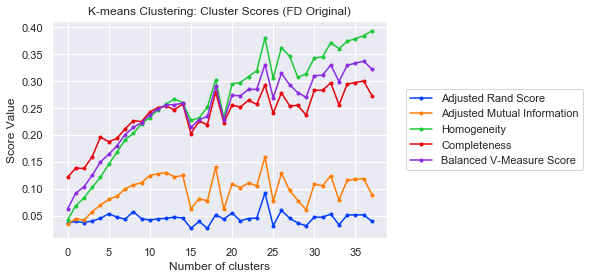

(38, 5)
clustering_figs_spectral_allfeats_fd_cluster_scores.png


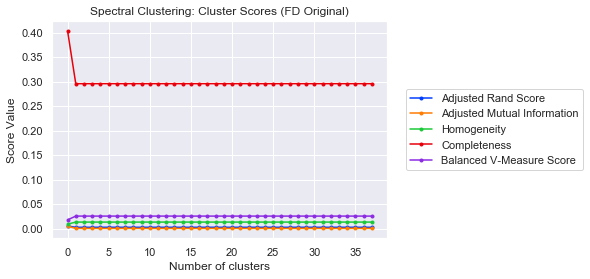

(38, 5)
clustering_figs_agg_allfeats_fd_cluster_scores.png


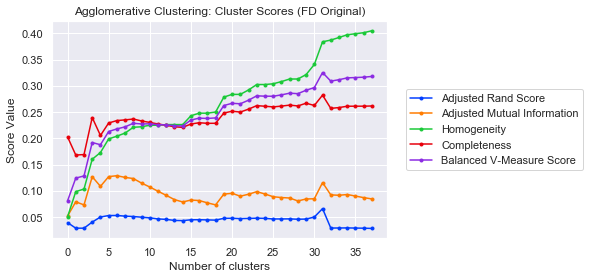

(38, 3)
clustering_figs_kmeans_allfeats_fd_model_scores.png


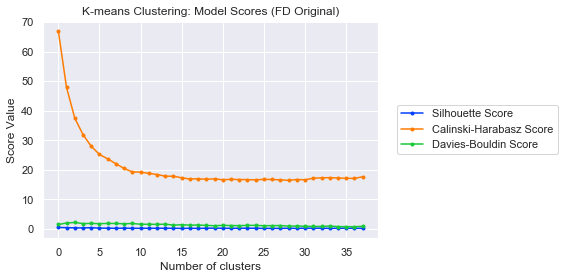

(38, 3)
clustering_figs_spectral_allfeats_fd_model_scores.png


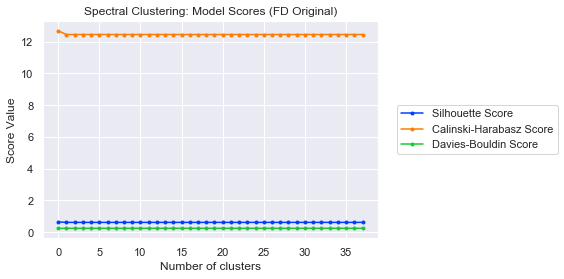

(38, 3)
clustering_figs_agg_allfeats_fd_model_scores.png


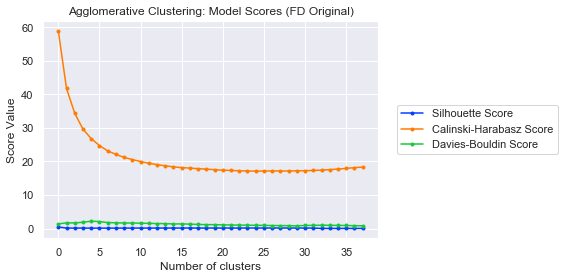

In [17]:
performUnsupervisedKAnalysis(df_fd_dag.values, df_classes["SiteNum"].values, titleFeats="FD Original", fnFeats="allfeats_fd")

## DVARS Original

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(38, 5)
clustering_figs_kmeans_allfeats_dvars_cluster_scores.png


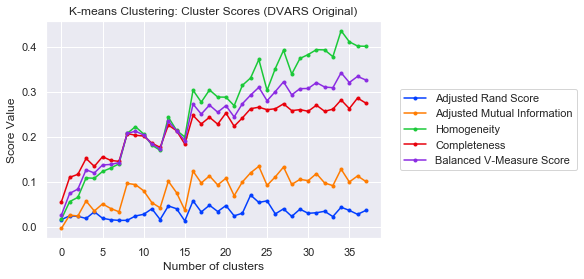

(38, 5)
clustering_figs_spectral_allfeats_dvars_cluster_scores.png


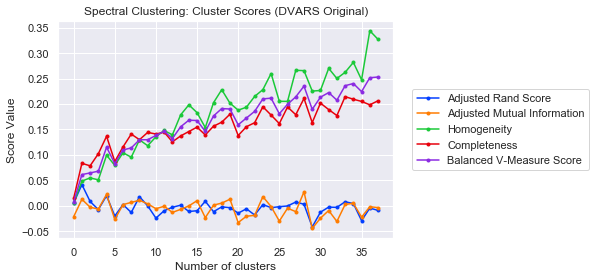

(38, 5)
clustering_figs_agg_allfeats_dvars_cluster_scores.png


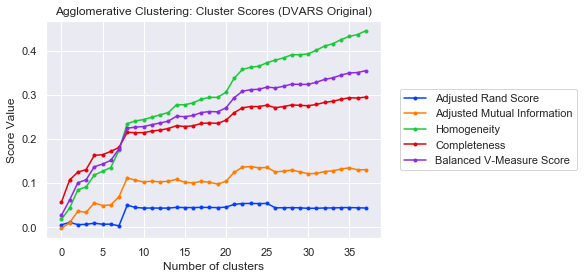

(38, 3)
clustering_figs_kmeans_allfeats_dvars_model_scores.png


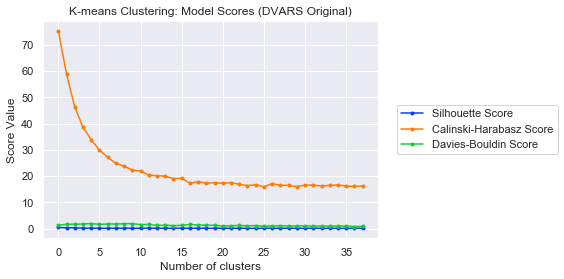

(38, 3)
clustering_figs_spectral_allfeats_dvars_model_scores.png


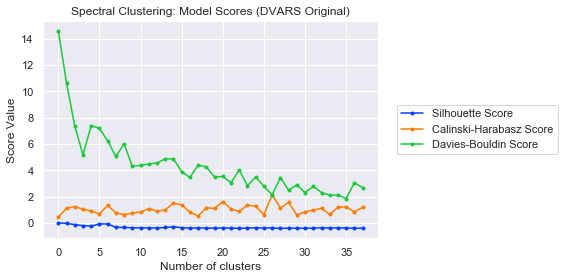

(38, 3)
clustering_figs_agg_allfeats_dvars_model_scores.png


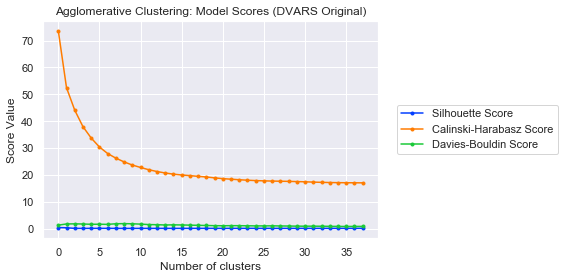

In [18]:
performUnsupervisedKAnalysis(df_dvars_dag.values, df_classes["SiteNum"].values, titleFeats="DVARS Original", fnFeats="allfeats_dvars")

## FD TSNE

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: Convergence

(38, 5)
clustering_figs_kmeans_tsne50_fd_cluster_scores.png


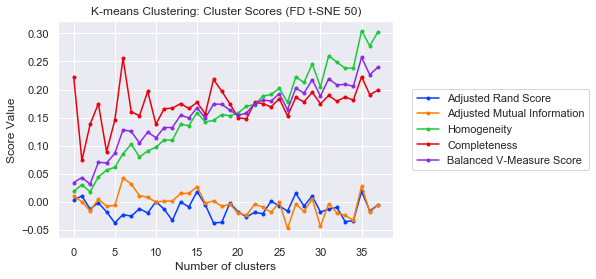

(38, 5)
clustering_figs_spectral_tsne50_fd_cluster_scores.png


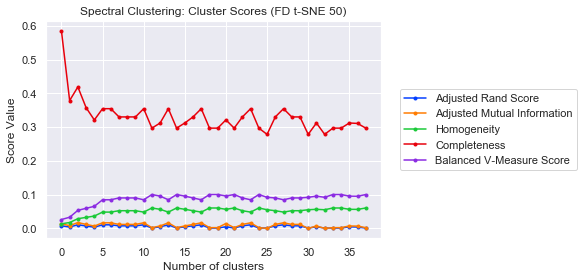

(38, 5)
clustering_figs_agg_tsne50_fd_cluster_scores.png


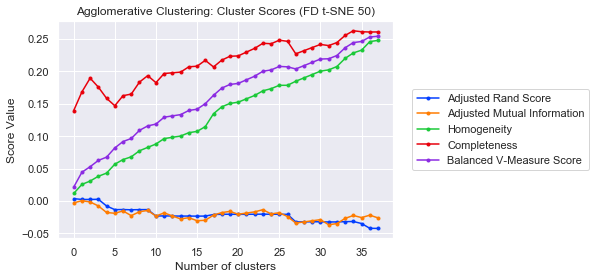

(38, 3)
clustering_figs_kmeans_tsne50_fd_model_scores.png


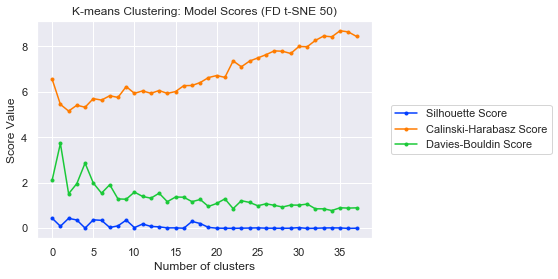

(38, 3)
clustering_figs_spectral_tsne50_fd_model_scores.png


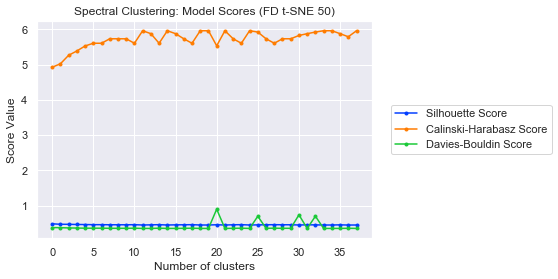

(38, 3)
clustering_figs_agg_tsne50_fd_model_scores.png


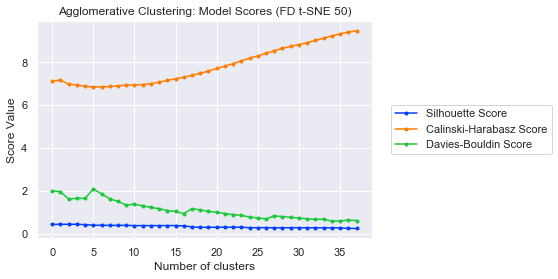

In [19]:
tsne_features = dim_redux.performTSNE(df_fd_dag, 50)
performUnsupervisedKAnalysis(tsne_features, df_classes["SiteNum"].values, titleFeats="FD t-SNE 50", fnFeats="tsne50_fd")

## DVARS TSNE

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packa

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (39). Possibly due to duplicate points in X.
  n_init=n_init)


(38, 5)
clustering_figs_kmeans_tsne50_dvars_cluster_scores.png


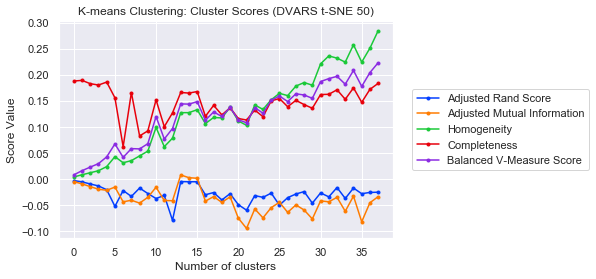

(38, 5)
clustering_figs_spectral_tsne50_dvars_cluster_scores.png


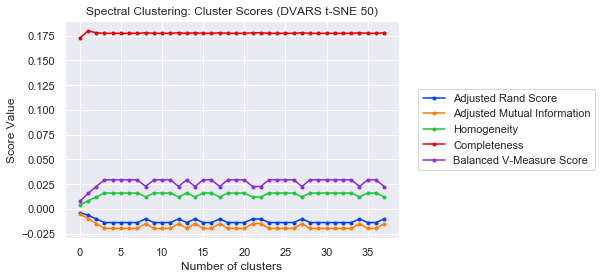

(38, 5)
clustering_figs_agg_tsne50_dvars_cluster_scores.png


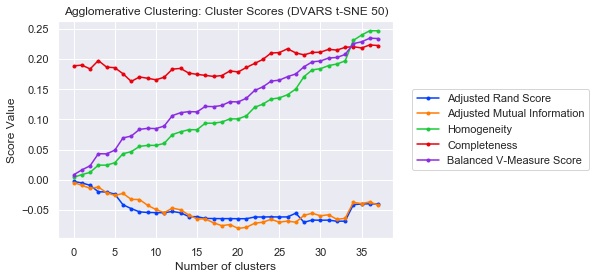

(38, 3)
clustering_figs_kmeans_tsne50_dvars_model_scores.png


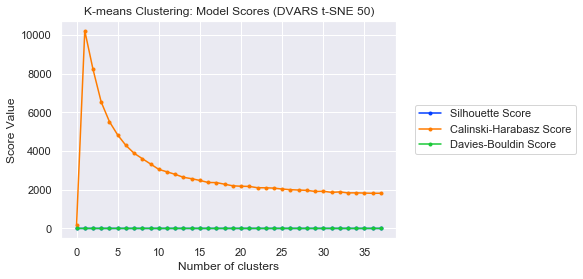

(38, 3)
clustering_figs_spectral_tsne50_dvars_model_scores.png


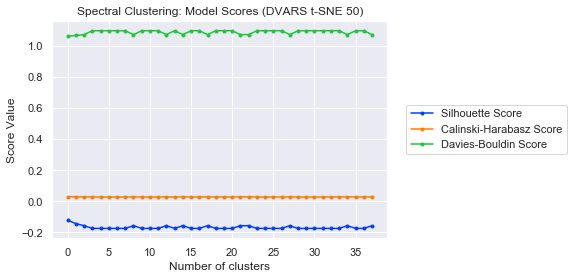

(38, 3)
clustering_figs_agg_tsne50_dvars_model_scores.png


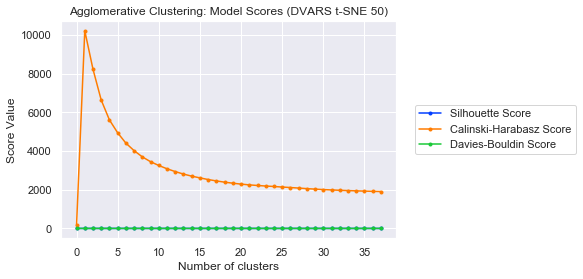

In [20]:
tsne_features = dim_redux.performTSNE(df_dvars_dag, 50)
performUnsupervisedKAnalysis(tsne_features, df_classes["SiteNum"].values, titleFeats="DVARS t-SNE 50", fnFeats="tsne50_dvars")

## FD PCA 50

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  n_init=n_init)
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWa

(38, 5)
clustering_figs_kmeans_pca50_fd_cluster_scores.png


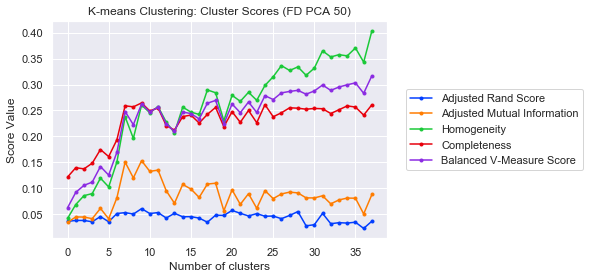

(38, 5)
clustering_figs_spectral_pca50_fd_cluster_scores.png


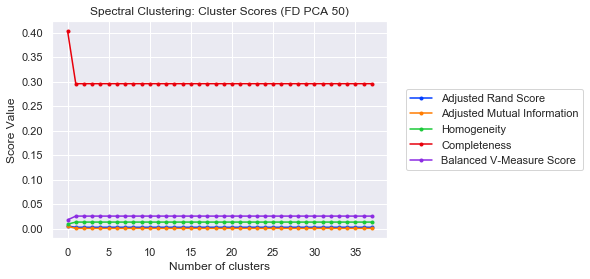

(38, 5)
clustering_figs_agg_pca50_fd_cluster_scores.png


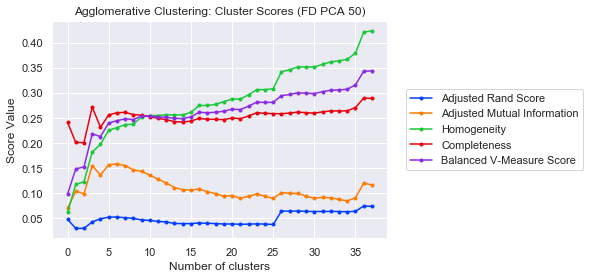

(38, 3)
clustering_figs_kmeans_pca50_fd_model_scores.png


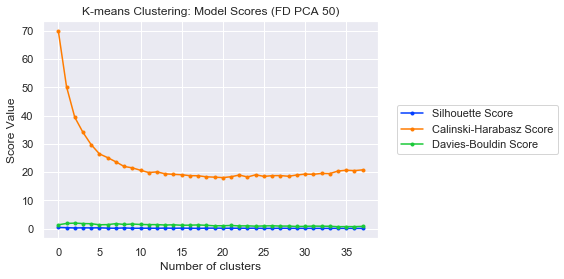

(38, 3)
clustering_figs_spectral_pca50_fd_model_scores.png


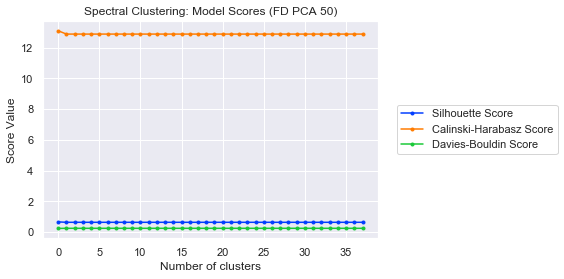

(38, 3)
clustering_figs_agg_pca50_fd_model_scores.png


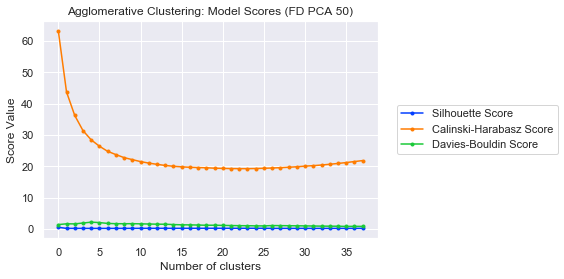

In [30]:
pca_features = dim_redux.performPCA(df_fd_dag, 50)
performUnsupervisedKAnalysis(pca_features, df_classes["SiteNum"].values, titleFeats="FD PCA 50", fnFeats="pca50_fd")

## DVARS PCA 50

/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(38, 5)
clustering_figs_kmeans_pca50_dvars_cluster_scores.png


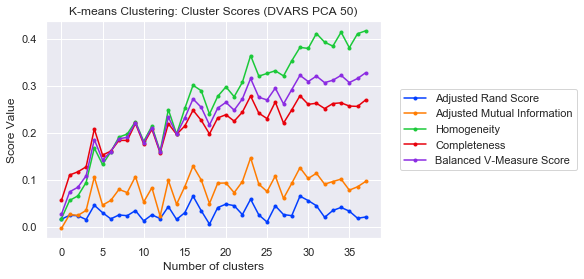

(38, 5)
clustering_figs_spectral_pca50_dvars_cluster_scores.png


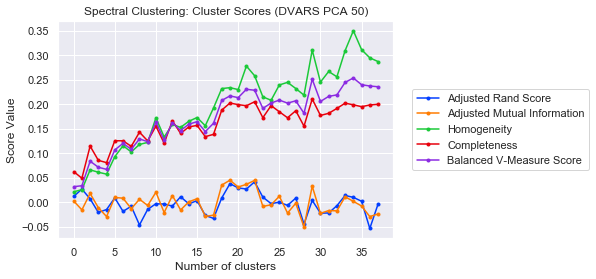

(38, 5)
clustering_figs_agg_pca50_dvars_cluster_scores.png


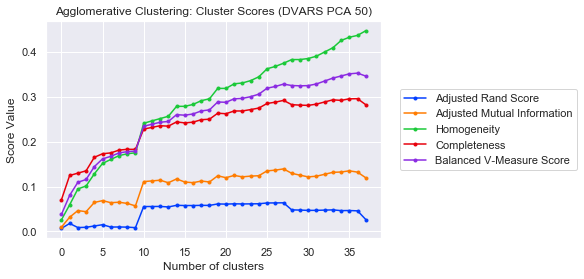

(38, 3)
clustering_figs_kmeans_pca50_dvars_model_scores.png


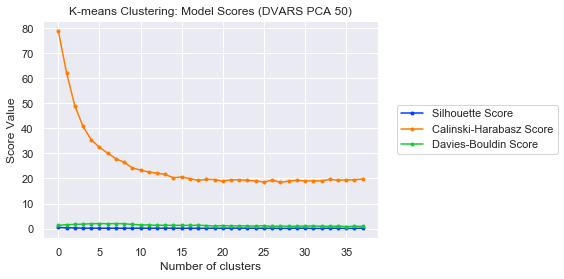

(38, 3)
clustering_figs_spectral_pca50_dvars_model_scores.png


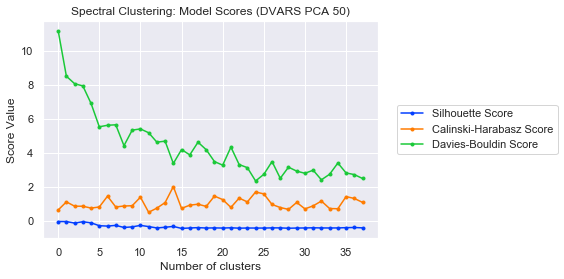

(38, 3)
clustering_figs_agg_pca50_dvars_model_scores.png


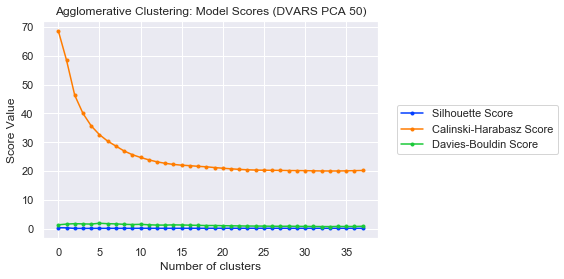

In [31]:
pca_features = dim_redux.performPCA(df_dvars_dag, 50)
performUnsupervisedKAnalysis(pca_features, df_classes["SiteNum"].values, titleFeats="DVARS PCA 50", fnFeats="pca50_dvars")

# Sandbox

In [23]:
# Testing PCA
# pca_features = performPCA(df_fd_dag)
# showClusterResults(pca_features, y_kmeans, title='Kmeans PCA')

In [24]:
# Testing UMAP
# umap_features = performUMAP(df_fd_dag)
# showClusterResults(umap_features, y_kmeans, title='Kmeans UMAP')

In [25]:
# Testing k-means
# y_spectral = spectralClustering(df_fd_dag, 6)
# print(y_spectral)

In [26]:
# # Testing TSNE
# tsne_features = performTSNE(df_fd_dag)
# showClusterResults(tsne_features, y_spectral, title="Spectral t-SNE")

# # Testing PCA
# pca_features = performPCA(df_fd_dag)
# showClusterResults(pca_features, y_spectral, title='Spectral PCA')

# # Testing UMAP
# umap_features = performUMAP(df_fd_dag)
# showClusterResults(umap_features, y_spectral, title='Spectral UMAP')

In [27]:
# viewDataList(df_fd_dag[0], 
#              yax="Framewise Displacement (mm)",
#              title="Framewise Displacement Example")

In [28]:
# viewDataList(df_dvars_dag[0], 
#              yax="DVARS (units)",
#              title="DVARS Example")

In [29]:
# viewDataArray(readTable(os.path.join(subject, "dag-fsl-mi-matrix.csv")))